# Harmonized Landsat Sentinel (HLS)

NOTE: this is a work in progress, results not thoroughly vetted!...

HLS is an analysis ready data product that synthesizes Landsat and Sentinel acquisitions for consistent surface
reflectance. This is important for characterizing physical changes to Earth's surface with better temporal sampling than can be achieved with one satellite alone. To normalize surface reflectance a series of correction must be applied to the original datasets, and to make them more user-friendly a common output grid is used and cloud-friendly formats such as Cloud-optimized Geotiff and STAC metadata are available. 

Our analysis goal is a time-series involving multiple bands. Specifically, We'll calculate a Normalized Difference Snow Index (NDSI) https://www.usgs.gov/landsat-missions/normalized-difference-snow-index. Along the way we'll setup a tidy Xarray dataset that includes a Cloud mask as a non-dimensional coordinate.

NDSI is calculated as normalized difference between spectral bands green (G) and the shortwave infrared (SWIR):

NDSI =  (Green – SWIR) / (Green + SWIR)

0 < NDSI < =1 is taken to be the probability of snow present. A pixel with NDSI <= 0.0 is considered snow-free.

In [1]:
import rioxarray
import rasterio
import geopandas as gpd
import pandas as pd
import requests
import pystac
import xarray as xr
import numpy as np
import seaborn as sns
import odc.stac
import odc.geo
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%config InlineBackend.figure_format='retina'

## Step 1. Find your data.

For the purpose of this notebook, we start with a pre-downloaded STAC catalog for HLS data spanning 2022-01 to 2023-01, covering ngozumpa glacier:


In [2]:
gfa = gpd.read_file('ngozumpa.geojson')
gfa.explore()

In [3]:
# Read in previously saved STAC ItemCollection
item_collection = pystac.ItemCollection.from_file('hls.json')
itemS2 = item_collection[1] #Sentinel-2 (S30)
itemS2

ID: HLS.S30.T45RVL.2022002T045211.v2.0
"Bounding Box: [85.982359, 27.030558, 87.099288, 28.0254]"
Datetime: 2022-01-02 05:01:06.270760+00:00
start_datetime: 2022-01-02T05:01:06.270760Z
end_datetime: 2022-01-02T05:01:06.270760Z
platform: sentinel-2a
instruments: ['msi']
eo:cloud_cover: 33.0
proj:epsg: 32645
view:sun_azimuth: 157.97824188
view:azimuth: 142.40559597


In [4]:
itemL = item_collection[3] #Landsat (L30)
itemL

ID: HLS.L30.T45RVL.2022004T044224.v2.0
"Bounding Box: [85.98346, 27.030558, 87.099288, 28.0254]"
Datetime: 2022-01-04 04:42:24.856957+00:00
start_datetime: 2022-01-04T04:42:24.856957Z
end_datetime: 2022-01-04T04:42:24.856957Z
platform: landsat-8
instruments: ['oli']
eo:cloud_cover: 36.0
proj:epsg: 32645
view:sun_azimuth: 152.80769647
view:azimuth: 136.14851214


In [5]:
def get_band_info(item):
    '''eo:band info from STAC metadata '''
    extra_fields = [a.extra_fields.get('eo:bands', [{'name':None}])[0] for a in item.assets.values()]
    
    df = gpd.pd.DataFrame(extra_fields).set_index('name').T
    return df

print('Sentinel-2 Common Band Names:')
get_band_info(itemS2)

Sentinel-2 Common Band Names:


name,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12,Fmask,SZA,SAA,VZA,VAA,None
common_name,coastal,blue,green,red,NaN,NaN,NaN,nir,NaN,NaN,cirrus,swir16,swir22,NaN,NaN,NaN,NaN,NaN,NaN
center_wavelength,0.4439,0.4966,0.56,0.6645,0.7039,0.7402,0.7825,0.8351,0.8648,0.945,1.3735,1.6137,2.22024,NaN,NaN,NaN,NaN,NaN,NaN
full_width_half_max,0.027,0.098,0.045,0.038,0.019,0.018,0.028,0.145,0.033,0.026,0.075,0.143,0.242,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print('Landsat Common Band Names:')
get_band_info(itemL)

Landsat Common Band Names:


name,B01,B02,B03,B04,B05,B06,B07,B09,B10,B11,Fmask,SZA,SAA,VZA,VAA,None
common_name,coastal,blue,green,red,nir,swir16,swir22,cirrus,lwir11,lwir12,NaN,NaN,NaN,NaN,NaN,NaN
center_wavelength,0.48,0.44,0.56,0.65,0.86,1.6,2.2,1.37,10.9,12.0,NaN,NaN,NaN,NaN,NaN,NaN
full_width_half_max,0.02,0.06,0.06,0.04,0.03,0.08,0.2,0.02,0.8,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
s = get_band_info(itemS2).T['common_name'].dropna()
common2band_sentinel = gpd.pd.Series(s.index.values, index=s).to_dict()

s = get_band_info(itemL).T['common_name'].dropna()
common2band_landsat = gpd.pd.Series(s.index.values, index=s).to_dict()

In [8]:
# STAC Catalog as a GeoDataFrame
gf = gpd.read_file('hls.json')
gf['time'] = gf.datetime.dt.tz_localize(None) 
gf.set_index('time',inplace=True)
gf.head(10)

,id,start_datetime,end_datetime,platform,instruments,eo:cloud_cover,proj:epsg,view:sun_azimuth,view:azimuth,sci:doi,datetime,geometry
time,,,,,,,,,,,,
2022-01-02 05:00:51.846,HLS.S30.T45RVM.2022002T045211.v2.0,2022-01-02 05:00:51.846000+00:00,2022-01-02 05:00:51.846000+00:00,sentinel-2a,[msi],98.0,32645,158.153022,107.791979,10.5067/HLS/HLSS30.002,2022-01-02 05:00:51.846000+00:00,"MULTIPOLYGON (((85.97367 28.92437, 87.10014 28..."
2022-01-02 05:01:06.271,HLS.S30.T45RVL.2022002T045211.v2.0,2022-01-02 05:01:06.271000+00:00,2022-01-02 05:01:06.271000+00:00,sentinel-2a,[msi],33.0,32645,157.978242,142.405596,10.5067/HLS/HLSS30.002,2022-01-02 05:01:06.271000+00:00,"MULTIPOLYGON (((85.98236 28.02167, 87.09929 28..."
2022-01-04 04:42:00.957,HLS.L30.T45RVM.2022004T044200.v2.0,2022-01-04 04:42:00.957000+00:00,2022-01-04 04:42:24.857000+00:00,landsat-8,[oli],78.0,32645,153.087425,108.987071,10.5067/HLS/HLSL30.002,2022-01-04 04:42:00.957000+00:00,"MULTIPOLYGON (((86.23710 28.92612, 87.10014 28..."
2022-01-04 04:42:24.857,HLS.L30.T45RVL.2022004T044224.v2.0,2022-01-04 04:42:24.857000+00:00,2022-01-04 04:42:24.857000+00:00,landsat-8,[oli],36.0,32645,152.807696,136.148512,10.5067/HLS/HLSL30.002,2022-01-04 04:42:24.857000+00:00,"MULTIPOLYGON (((85.98346 27.90415, 86.01440 28..."
2022-01-07 05:00:46.197,HLS.S30.T45RVM.2022007T045159.v2.0,2022-01-07 05:00:46.197000+00:00,2022-01-07 05:00:46.197000+00:00,sentinel-2b,[msi],67.0,32645,157.289712,108.889788,10.5067/HLS/HLSS30.002,2022-01-07 05:00:46.197000+00:00,"MULTIPOLYGON (((85.97367 28.92437, 87.10014 28..."
2022-01-07 05:01:00.626,HLS.S30.T45RVL.2022007T045159.v2.0,2022-01-07 05:01:00.626000+00:00,2022-01-07 05:01:00.626000+00:00,sentinel-2b,[msi],97.0,32645,157.102917,142.762532,10.5067/HLS/HLSS30.002,2022-01-07 05:01:00.626000+00:00,"MULTIPOLYGON (((85.98236 28.02167, 87.09929 28..."
2022-01-12 04:42:00.440,HLS.L30.T45RVM.2022012T044200.v2.0,2022-01-12 04:42:00.440000+00:00,2022-01-12 04:42:24.327000+00:00,landsat-9,[oli],91.0,32645,151.660900,108.861589,10.5067/HLS/HLSL30.002,2022-01-12 04:42:00.440000+00:00,"MULTIPOLYGON (((86.23187 28.92609, 87.10014 28..."
2022-01-12 04:42:24.327,HLS.L30.T45RVL.2022012T044224.v2.0,2022-01-12 04:42:24.327000+00:00,2022-01-12 04:42:24.327000+00:00,landsat-9,[oli],100.0,32645,151.368153,137.703086,10.5067/HLS/HLSL30.002,2022-01-12 04:42:24.327000+00:00,"MULTIPOLYGON (((85.98325 27.92689, 86.00860 28..."
2022-01-12 05:00:51.266,HLS.S30.T45RVM.2022012T045141.v2.0,2022-01-12 05:00:51.266000+00:00,2022-01-12 05:00:51.266000+00:00,sentinel-2a,[msi],97.0,32645,156.433090,107.630319,10.5067/HLS/HLSS30.002,2022-01-12 05:00:51.266000+00:00,"MULTIPOLYGON (((85.97367 28.92437, 87.10014 28..."


### Step 2 Get to know your data. 

Ideally data is self-describing, but more often than not you'll have to read up on the details on a data provider website https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/harmonized-landsat-sentinel-2-hls-overview/


In [9]:
# AUTHENTICATION handling for NASA earthdata login (requires ~/.netrc)

os.environ['GDAL_HTTP_COOKIEJAR'] = '/tmp/cookie'
os.environ['GDAL_HTTP_COOKIEFILE'] = '/tmp/cookie'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN'] = 'EMPTY_DIR'

In [10]:
# Start with a single band (MGRS Square = T45RVM)
urlS2 = itemS2.assets.get(common2band_sentinel['swir16']).href
print(urlS2)
dsS2 = xr.open_dataset(urlS2, engine='rasterio')
dsS2

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSS30.020/HLS.S30.T45RVL.2022002T045211.v2.0/HLS.S30.T45RVL.2022002T045211.v2.0.B11.tif


<xarray.Dataset>
Dimensions:      (band: 1, x: 3660, y: 3660)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.097e+05
  * y            (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [11]:
urlL = itemL.assets.get(common2band_landsat['swir16']).href
print(urlL)
dsL = xr.open_dataset(urlL, engine='rasterio')
dsL

https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T45RVL.2022004T044224.v2.0/HLS.L30.T45RVL.2022004T044224.v2.0.B06.tif


<xarray.Dataset>
Dimensions:      (band: 1, x: 3660, y: 3660)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.097e+05
  * y            (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [12]:
# To construct a tidy dataset we have work to do!

# 1. we lost timestamp information (in the filename)
# 2. we have a default variablename instead of something to keep track of the physical measurement (swir16)
# 3. we don't have much for contextual information (cloud%estimate, solar angle, etc), which we could add

dsL = dsL.rename({'band_data':'swir16','band':'time'})
dsL['time'] = [pd.to_datetime(urlL.split('.')[-5], format='%Y%jT%H%M%S')]
dsL = dsL.assign_coords(platform=('time',['landsat']))

dsS2 = dsS2.rename({'band_data':'swir16','band':'time'})
dsS2['time'] = [pd.to_datetime(urlS2.split('.')[-5], format='%Y%jT%H%M%S')]
dsS2 = dsS2.assign_coords(platform=('time',['sentinel']))

DS = xr.merge([dsS2, dsL])

# You can see this would get very tedious for a lot of files.
# Instead we need a way to intelligently open the catalog with Xarray. This is both a data formatting and software
# solution. We need the software to account for things we're doing like renaming based on common name.

DS

<xarray.Dataset>
Dimensions:      (time: 2, x: 3660, y: 3660)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-02T04:52:11 2022-01-04T04:42:24
  * x            (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.097e+05
  * y            (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
    spatial_ref  int64 0
    platform     (time) object 'sentinel' 'landsat'
Data variables:
    swir16       (time, y, x) float32 -0.0019 -0.0034 -0.0006 ... 0.0938 0.0602

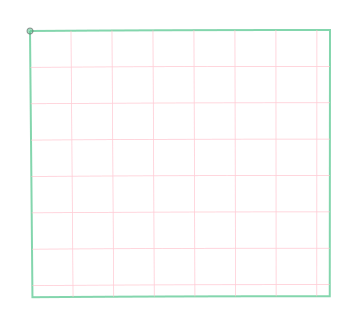

In [13]:
# Take control of the grid (in this case we use the native grid, so no resampling is necessary)
DS.odc.geobox

In [14]:
# Can work with Coarse resolution for prototyping
coarse_box = odc.geo.geobox.scaled_down_geobox(DS.odc.geobox, 4)

In [15]:
ds = odc.stac.load(item_collection,
                     geobox=coarse_box,
                     #geobox=ds.odc.geobox,
                     bands=["green", "swir16", "Fmask"],
                     chunks={'x': 256, 'y': 256}, # To parallelize computation with dask
                    )
ds

<xarray.Dataset>
Dimensions:      (y: 915, x: 915, time: 226)
Coordinates:
  * y            (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
  * x            (x) float64 4e+05 4.001e+05 4.003e+05 ... 5.096e+05 5.097e+05
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2022-01-02T05:00:51.846240 ... 2022-12...
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    swir16       (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    Fmask        (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

In [16]:
ds.nbytes/1e9

2.270570652

In [17]:
# Can still add more contextual medata, the easiest way to do this is to use a pandas dataframe
# since xarray uses pandas for indexing!
# Dataframe from STAC Item Collection
gf = gpd.read_file('hls.json')
gf['time'] = gf.datetime.dt.tz_localize(None) 
gf.set_index('time',inplace=True)
gf.head(3)

,id,start_datetime,end_datetime,platform,instruments,eo:cloud_cover,proj:epsg,view:sun_azimuth,view:azimuth,sci:doi,datetime,geometry
time,,,,,,,,,,,,
2022-01-02 05:00:51.846,HLS.S30.T45RVM.2022002T045211.v2.0,2022-01-02 05:00:51.846000+00:00,2022-01-02 05:00:51.846000+00:00,sentinel-2a,[msi],98.0,32645,158.153022,107.791979,10.5067/HLS/HLSS30.002,2022-01-02 05:00:51.846000+00:00,"MULTIPOLYGON (((85.97367 28.92437, 87.10014 28..."
2022-01-02 05:01:06.271,HLS.S30.T45RVL.2022002T045211.v2.0,2022-01-02 05:01:06.271000+00:00,2022-01-02 05:01:06.271000+00:00,sentinel-2a,[msi],33.0,32645,157.978242,142.405596,10.5067/HLS/HLSS30.002,2022-01-02 05:01:06.271000+00:00,"MULTIPOLYGON (((85.98236 28.02167, 87.09929 28..."
2022-01-04 04:42:00.957,HLS.L30.T45RVM.2022004T044200.v2.0,2022-01-04 04:42:00.957000+00:00,2022-01-04 04:42:24.857000+00:00,landsat-8,[oli],78.0,32645,153.087425,108.987071,10.5067/HLS/HLSL30.002,2022-01-04 04:42:00.957000+00:00,"MULTIPOLYGON (((86.23710 28.92612, 87.10014 28..."


In [18]:
# Keep only some medata
metadata_cols = ['id','platform','instruments','eo:cloud_cover','view:sun_azimuth','view:azimuth']
df = gf.loc[:,metadata_cols]

# Can also add additional derived values for convenience
df['mgrs'] = df.id.str[8:14]

df.head(4)

,id,platform,instruments,eo:cloud_cover,view:sun_azimuth,view:azimuth,mgrs
time,,,,,,,
2022-01-02 05:00:51.846,HLS.S30.T45RVM.2022002T045211.v2.0,sentinel-2a,[msi],98.0,158.153022,107.791979,T45RVM
2022-01-02 05:01:06.271,HLS.S30.T45RVL.2022002T045211.v2.0,sentinel-2a,[msi],33.0,157.978242,142.405596,T45RVL
2022-01-04 04:42:00.957,HLS.L30.T45RVM.2022004T044200.v2.0,landsat-8,[oli],78.0,153.087425,108.987071,T45RVM
2022-01-04 04:42:24.857,HLS.L30.T45RVL.2022004T044224.v2.0,landsat-8,[oli],36.0,152.807696,136.148512,T45RVL


In [19]:
# Use strings instead of lists for instruments
df['instruments'] = df.instruments.apply(lambda x: x[0])

In [20]:
df.instruments.unique() # OLI = landsat, MSI = sentinel2

array(['msi', 'oli'], dtype=object)

In [21]:
df.platform.unique()

array(['sentinel-2a', 'landsat-8', 'sentinel-2b', 'landsat-9'],
      dtype=object)

In [22]:
# Geopandas drops any numbers beyond miliseconds b/c other GIS libraries like GDAL have limited time precision
# more details: https://github.com/geopandas/geopandas/pull/2202
# Open ODC-stac bug on this...
ds['time'] = ds.time.dt.round(freq="ms").values

In [23]:
ds = ds.assign_coords(**df)

In [24]:
ds

<xarray.Dataset>
Dimensions:           (y: 915, x: 915, time: 226)
Coordinates:
  * y                 (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
  * x                 (x) float64 4e+05 4.001e+05 ... 5.096e+05 5.097e+05
    spatial_ref       int32 0
  * time              (time) datetime64[ns] 2022-01-02T05:00:51.846000 ... 20...
    id                (time) object 'HLS.S30.T45RVM.2022002T045211.v2.0' ... ...
    platform          (time) object 'sentinel-2a' 'sentinel-2a' ... 'landsat-9'
    instruments       (time) object 'msi' 'msi' 'oli' ... 'msi' 'oli' 'oli'
    eo:cloud_cover    (time) float64 98.0 33.0 78.0 36.0 ... 93.0 32.0 85.0 59.0
    view:sun_azimuth  (time) float64 158.2 158.0 153.1 ... 158.8 154.0 153.7
    view:azimuth      (time) float64 107.8 142.4 109.0 ... 142.5 109.7 140.0
    mgrs              (time) object 'T45RVM' 'T45RVL' ... 'T45RVM' 'T45RVL'
Data variables:
    green             (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    swir16            (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    Fmask             (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

In [25]:
# We can now subset our data with metadata in coordinates!
#ds['mgrs']=='T45RVM'
#ds["eo:cloud_cover"] < 20

# Not sure this really answers it https://stackoverflow.com/questions/60089131/how-to-use-boolean-indexing-for-an-xarray-dataset
#ds[ds["eo:cloud_cover"] < 20] #ValueError: Unsupported key-type <class 'xarray.core.dataarray.DataArray'> # needs to be another dataset?
#ds.green[ds["eo:cloud_cover"] < 20] # can only use this indexing syntax with dataarrays?

# https://stackoverflow.com/questions/75179116/equivalent-to-pandas-boolean-indexing-for-xarray
#ds.sel(time=ds["eo:cloud_cover"] < 20) #somewhat non-intuitive syntax but works!

# Subset to single MGRS tile
ds = ds.sel(time=(ds.mgrs=='T45RVL')) # South
#ds = ds.sel(time=(ds.mgrs=='T45RVM')) # North

In [26]:
ds

<xarray.Dataset>
Dimensions:           (y: 915, x: 915, time: 110)
Coordinates:
  * y                 (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
  * x                 (x) float64 4e+05 4.001e+05 ... 5.096e+05 5.097e+05
    spatial_ref       int32 0
  * time              (time) datetime64[ns] 2022-01-02T05:01:06.271000 ... 20...
    id                (time) object 'HLS.S30.T45RVL.2022002T045211.v2.0' ... ...
    platform          (time) object 'sentinel-2a' 'landsat-8' ... 'landsat-9'
    instruments       (time) object 'msi' 'oli' 'msi' ... 'msi' 'msi' 'oli'
    eo:cloud_cover    (time) float64 33.0 36.0 97.0 100.0 ... 37.0 32.0 59.0
    view:sun_azimuth  (time) float64 158.0 152.8 157.1 ... 159.5 158.8 153.7
    view:azimuth      (time) float64 142.4 136.1 142.8 ... 143.4 142.5 140.0
    mgrs              (time) object 'T45RVL' 'T45RVL' ... 'T45RVL' 'T45RVL'
Data variables:
    green             (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    swir16            (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>
    Fmask             (time, y, x) float32 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

/home/jovyan/.local/envs/odc/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


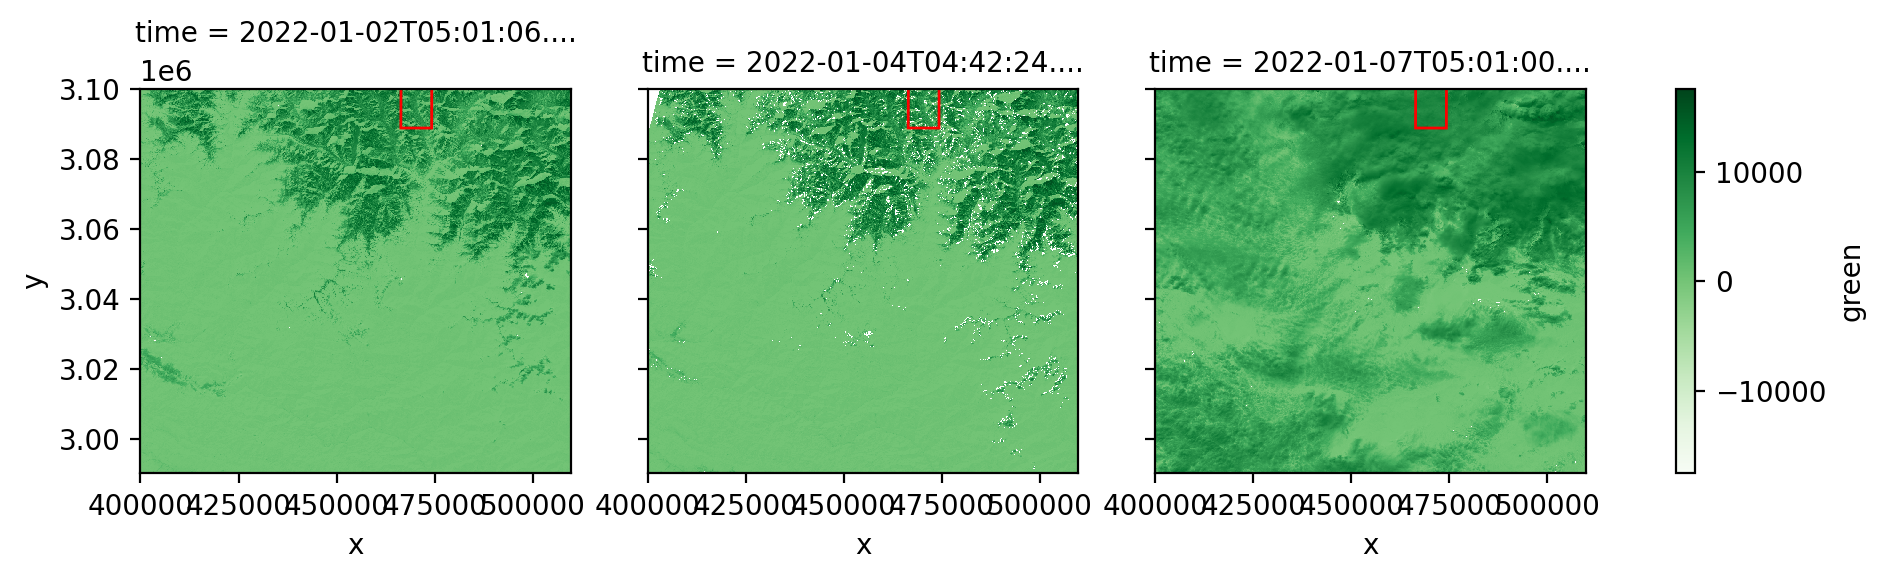

In [27]:
# Plot the first 3 frames at lower resolution
# NOTE: double check mask and scale applied for single bands (shouldn't matter for indices b/c all have scale=0.0001
facet_grid = ds.green.isel(time=slice(0,3)).plot(col='time', cmap='Greens', robust=False)
s = gfa.to_crs(ds.rio.crs).iloc[0] # geoseries

# PLot our original area of interest on this map
# Iterate over facet grid to modify:
for ax in facet_grid.axes.flatten():
    rect = patches.Polygon(list(s.geometry.boundary.coords), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect);

In [28]:
# Plot timeseries for AOI
ts = ds.rio.clip_box(**gfa.to_crs(ds.rio.crs).bounds).mean(['x','y'])

In [29]:
ndsi = (ts.green - ts.swir16) / (ts.green + ts.swir16)

In [30]:
ndsi = ndsi.compute()

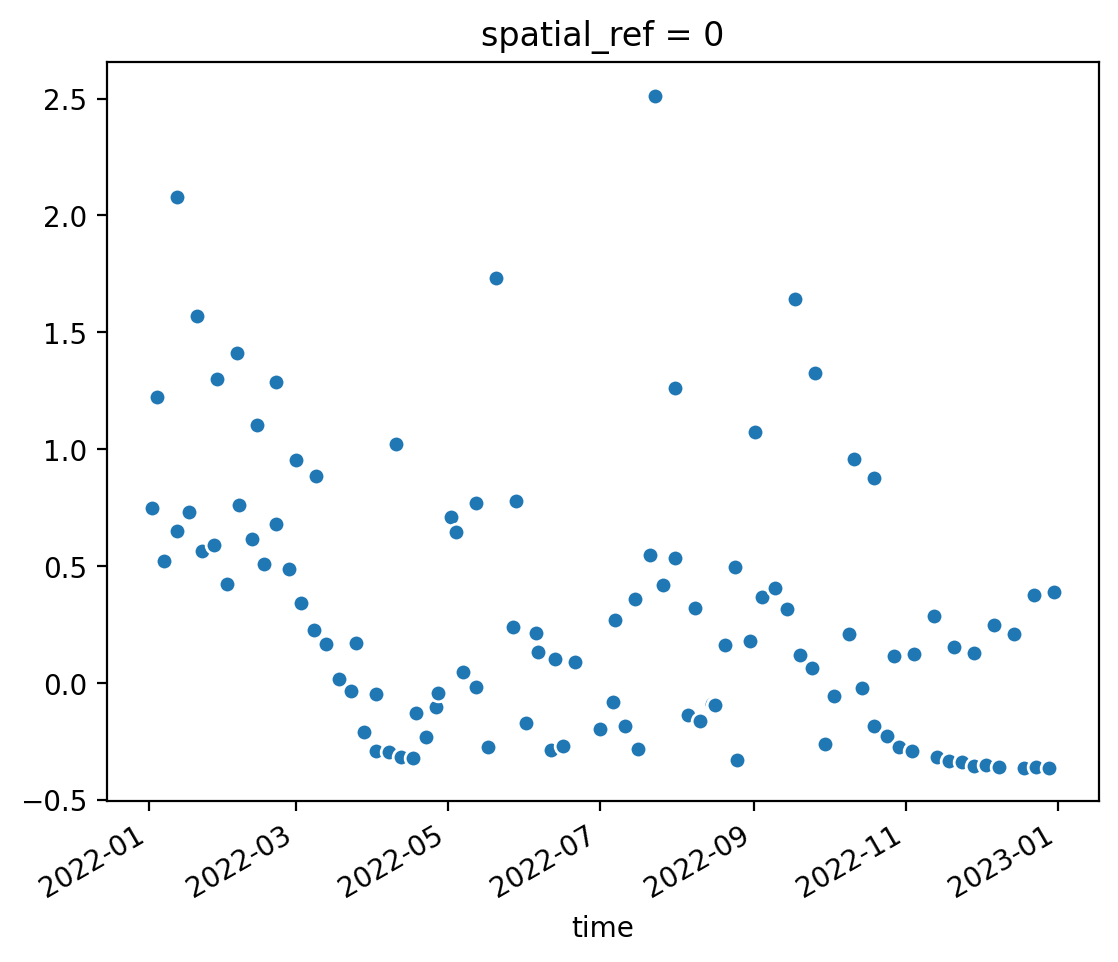

In [31]:
ndsi.plot.scatter();

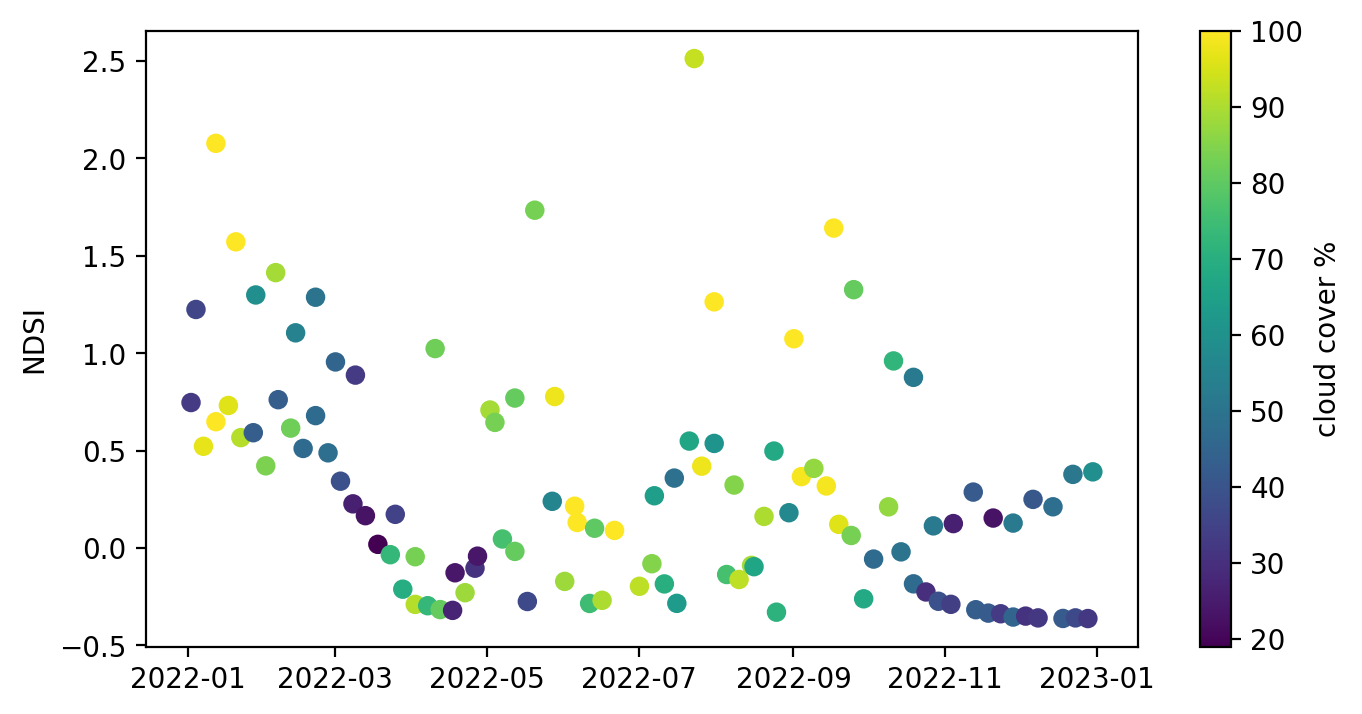

In [32]:
# Because we have the metadata we can take advantage of it in plots
plt.subplots(figsize=(8,4))
plt.scatter(ndsi.time, ndsi.values, c=ndsi['eo:cloud_cover'])#, marker=ndsi['platform'] (trying to use different symbols for different satellites)
cb = plt.colorbar()
cb.set_label('cloud cover %')
plt.ylabel('NDSI');

In [33]:
df = ndsi.to_dataframe(name='ndsi')
df.head()

,id,platform,instruments,eo:cloud_cover,view:sun_azimuth,view:azimuth,mgrs,spatial_ref,ndsi
time,,,,,,,,,
2022-01-02 05:01:06.271,HLS.S30.T45RVL.2022002T045211.v2.0,sentinel-2a,msi,33.0,157.978242,142.405596,T45RVL,0,0.746491
2022-01-04 04:42:24.857,HLS.L30.T45RVL.2022004T044224.v2.0,landsat-8,oli,36.0,152.807696,136.148512,T45RVL,0,1.224222
2022-01-07 05:01:00.626,HLS.S30.T45RVL.2022007T045159.v2.0,sentinel-2b,msi,97.0,157.102917,142.762532,T45RVL,0,0.521934
2022-01-12 04:42:24.327,HLS.L30.T45RVL.2022012T044224.v2.0,landsat-9,oli,100.0,151.368153,137.703086,T45RVL,0,2.076879
2022-01-12 05:01:05.698,HLS.S30.T45RVL.2022012T045141.v2.0,sentinel-2a,msi,100.0,156.232854,141.966773,T45RVL,0,0.648106


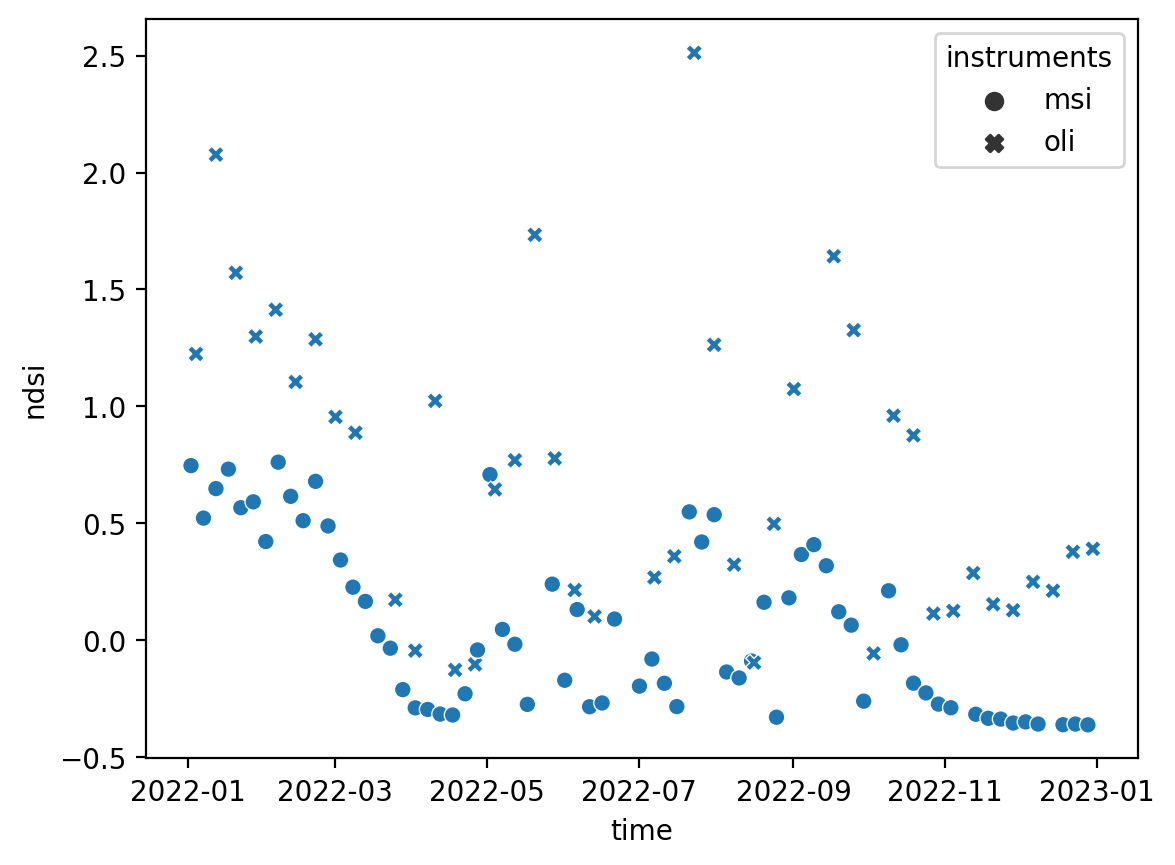

In [34]:
sns.scatterplot(data=df, x='time', y='ndsi', style='instruments');

In [35]:
ds.isel(time=-1).id

<xarray.DataArray 'id' ()>
array('HLS.L30.T45RVL.2022364T044236.v2.0', dtype=object)
Coordinates:
    spatial_ref       int32 0
    time              datetime64[ns] 2022-12-30T04:42:36.540000
    id                object 'HLS.L30.T45RVL.2022364T044236.v2.0'
    platform          object 'landsat-9'
    instruments       object 'oli'
    eo:cloud_cover    float64 59.0
    view:sun_azimuth  float64 153.7
    view:azimuth      float64 140.0
    mgrs              object 'T45RVL'

In [36]:
def extract_masks(fmask):
    """ as input expects Fmask array with (x,y) shape, 
    returns 5 numpy arrays of (x,y) shape for every mask value 
    ignore aerosol level masks for now
    """
    nmasks = 8
    explode = (fmask.shape[0], fmask.shape[1], nmasks)
    
    unpacked = np.unpackbits(fmask.astype('uint8'), axis=1, bitorder='little')
    boolean_masks = unpacked.reshape(explode).astype('bool')
    
    # could change aerosol into single array with values 0:3

    return boolean_masks[:,:,:6]


test = xr.apply_ufunc(
               extract_masks,
               ds.Fmask.isel(time=-1),                                                                                                                 
               input_core_dims = [['y','x']],
               output_core_dims = [['y','x','mask']],
               vectorize=True, # loops over time   
               dask='allowed',
              )

In [37]:
masks = extract_masks(ds.Fmask.isel(time=-1).data)
masks.shape

(915, 915, 6)

In [38]:
mask_order = ['cirrus','cloud','adjacent','shadow','snow','water']
masks = test.assign_coords(mask=mask_order).to_dataset(dim='mask')

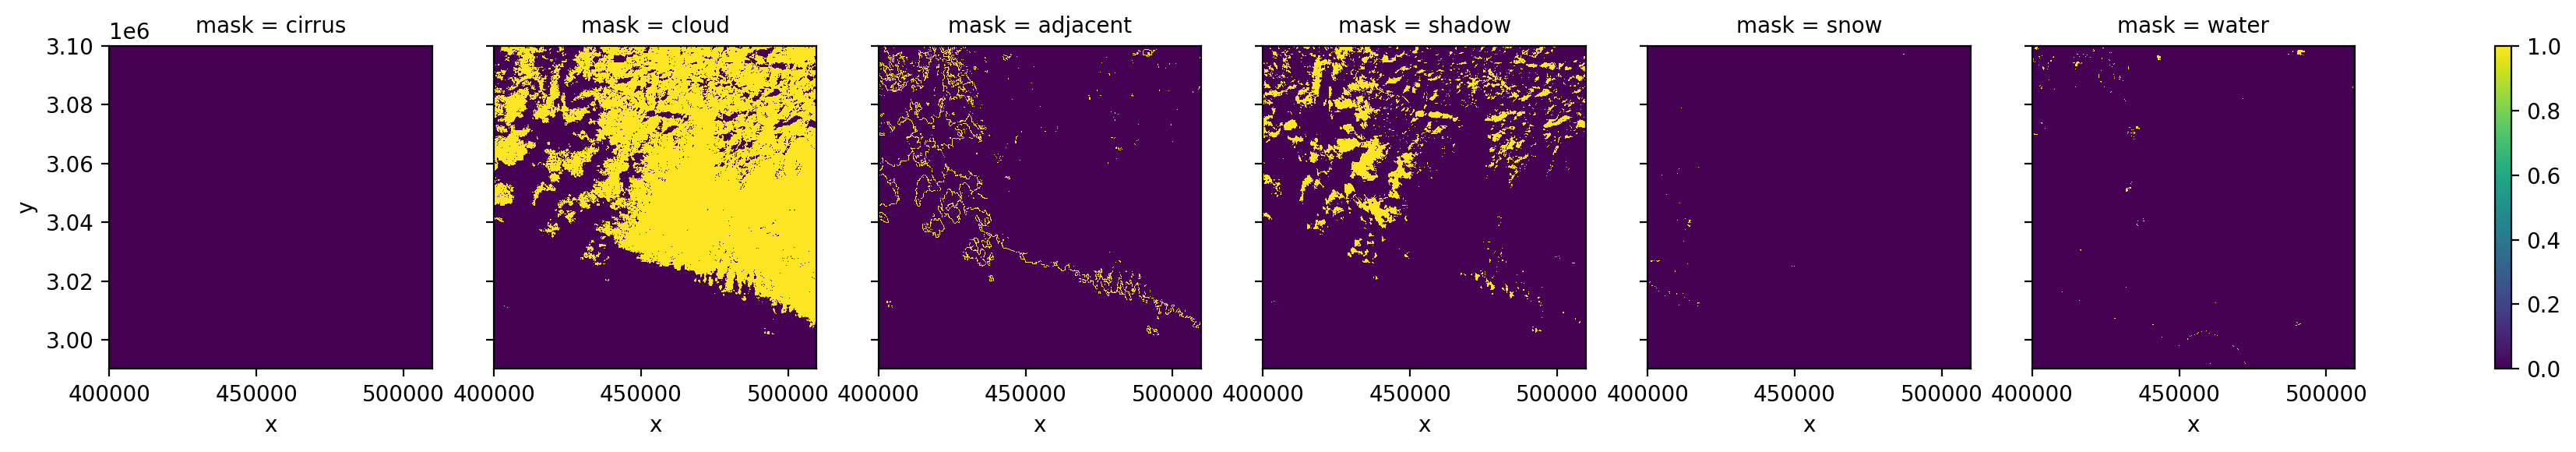

In [39]:
masks.to_array(dim='mask').plot(col='mask'); 
# NOTE: can have biased cloud cover estimates in desert for Sentinel2
# https://github.com/microsoft/PlanetaryComputer/discussions/218

In [40]:
masks

<xarray.Dataset>
Dimensions:           (y: 915, x: 915)
Coordinates:
  * y                 (y) float64 3.1e+06 3.1e+06 3.1e+06 ... 2.99e+06 2.99e+06
  * x                 (x) float64 4e+05 4.001e+05 ... 5.096e+05 5.097e+05
    spatial_ref       int32 0
    time              datetime64[ns] 2022-12-30T04:42:36.540000
    id                object 'HLS.L30.T45RVL.2022364T044236.v2.0'
    platform          object 'landsat-9'
    instruments       object 'oli'
    eo:cloud_cover    float64 59.0
    view:sun_azimuth  float64 153.7
    view:azimuth      float64 140.0
    mgrs              object 'T45RVL'
Data variables:
    cirrus            (y, x) bool False False False False ... False False False
    cloud             (y, x) bool False False False False ... False False False
    adjacent          (y, x) bool False False False False ... False False False
    shadow            (y, x) bool False False False False ... False False False
    snow              (y, x) bool False False False False ... False False False
    water             (y, x) bool False False False False ... False False False

In [41]:
ds_clipped = ds.rio.clip_box(**gfa.to_crs(ds.rio.crs).bounds)
ds_clipped

<xarray.Dataset>
Dimensions:           (y: 93, x: 67, time: 110)
Coordinates:
  * y                 (y) float64 3.1e+06 3.1e+06 ... 3.089e+06 3.089e+06
  * x                 (x) float64 4.664e+05 4.665e+05 ... 4.742e+05 4.743e+05
  * time              (time) datetime64[ns] 2022-01-02T05:01:06.271000 ... 20...
    id                (time) object 'HLS.S30.T45RVL.2022002T045211.v2.0' ... ...
    platform          (time) object 'sentinel-2a' 'landsat-8' ... 'landsat-9'
    instruments       (time) object 'msi' 'oli' 'msi' ... 'msi' 'msi' 'oli'
    eo:cloud_cover    (time) float64 33.0 36.0 97.0 100.0 ... 37.0 32.0 59.0
    view:sun_azimuth  (time) float64 158.0 152.8 157.1 ... 159.5 158.8 153.7
    view:azimuth      (time) float64 142.4 136.1 142.8 ... 143.4 142.5 140.0
    mgrs              (time) object 'T45RVL' 'T45RVL' ... 'T45RVL' 'T45RVL'
    spatial_ref       int64 0
Data variables:
    green             (time, y, x) float32 dask.array<chunksize=(1, 93, 67), meta=np.ndarray>
    swir16            (time, y, x) float32 dask.array<chunksize=(1, 93, 67), meta=np.ndarray>
    Fmask             (time, y, x) float32 dask.array<chunksize=(1, 93, 67), meta=np.ndarray>

In [42]:
# since this is small, work just with numpy arrays
ds_clipped = ds_clipped.compute()

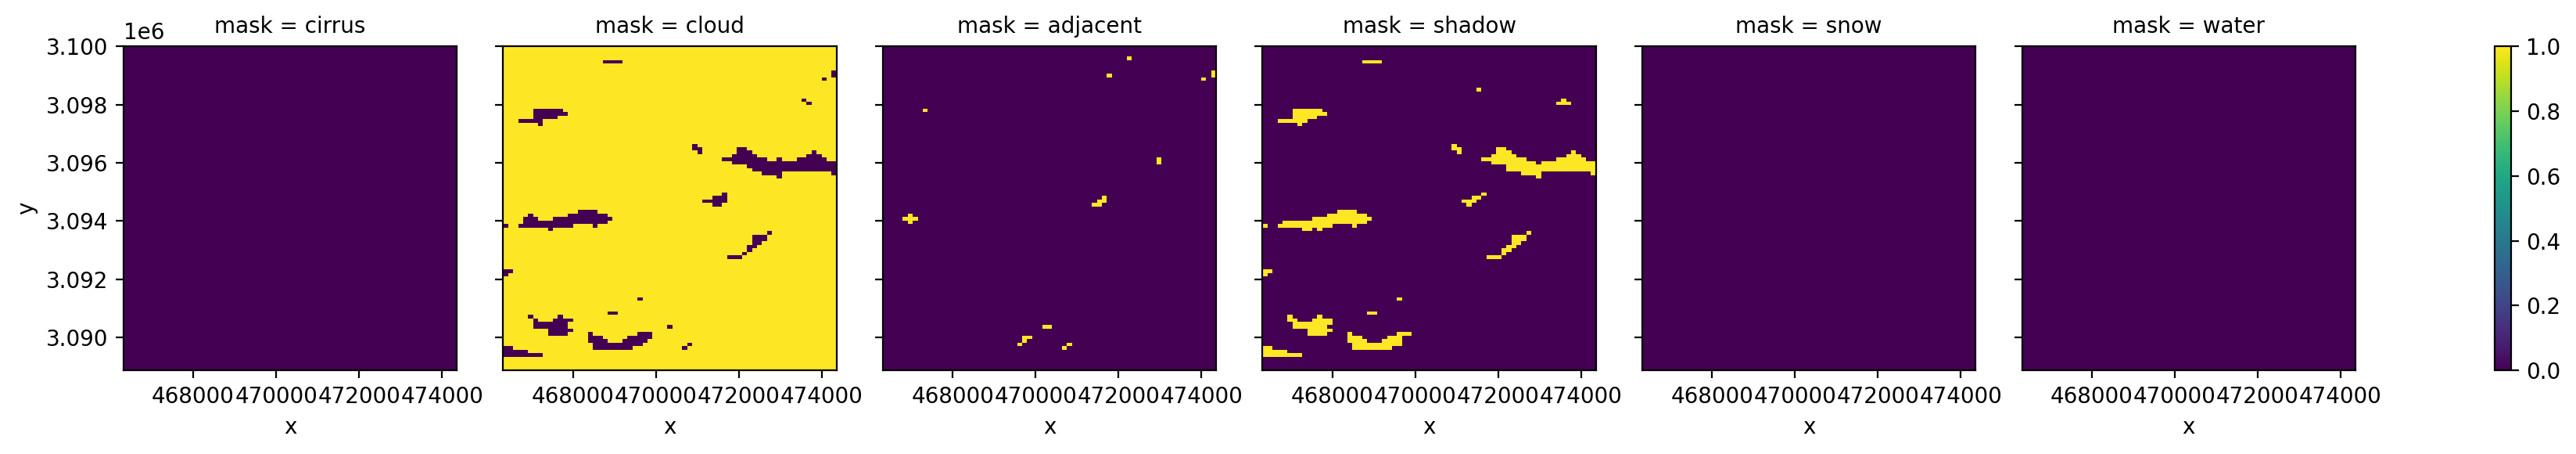

In [43]:
test = xr.apply_ufunc(
               extract_masks,
               ds_clipped.Fmask.isel(time=0),                                                                                                                 
               input_core_dims = [['y','x']],
               output_core_dims = [['y','x','mask']],
               vectorize=True, # loops over time   
               dask='allowed',
              )

masks = test.assign_coords(mask=mask_order).to_dataset(dim='mask')
masks.to_array(dim='mask').plot(col='mask'); # Likely an example of bad estimate of cloud cover in desert for Sentinel2

In [44]:
%%time

masks = xr.apply_ufunc(extract_masks,
               ds_clipped.Fmask,#.isel(time=slice(0,10)),                                                                                                                 
               input_core_dims = [['y','x']],
               output_core_dims = [['y','x','mask']],
               vectorize=True, # loops over time   
               dask='allowed',
              )

CPU times: user 10.8 ms, sys: 972 µs, total: 11.8 ms
Wall time: 10.4 ms


In [45]:
dsmask = masks.assign_coords(mask=mask_order).to_dataset(dim='mask')
dsmask

<xarray.Dataset>
Dimensions:           (time: 110, y: 93, x: 67)
Coordinates:
  * y                 (y) float64 3.1e+06 3.1e+06 ... 3.089e+06 3.089e+06
  * x                 (x) float64 4.664e+05 4.665e+05 ... 4.742e+05 4.743e+05
  * time              (time) datetime64[ns] 2022-01-02T05:01:06.271000 ... 20...
    id                (time) object 'HLS.S30.T45RVL.2022002T045211.v2.0' ... ...
    platform          (time) object 'sentinel-2a' 'landsat-8' ... 'landsat-9'
    instruments       (time) object 'msi' 'oli' 'msi' ... 'msi' 'msi' 'oli'
    eo:cloud_cover    (time) float64 33.0 36.0 97.0 100.0 ... 37.0 32.0 59.0
    view:sun_azimuth  (time) float64 158.0 152.8 157.1 ... 159.5 158.8 153.7
    view:azimuth      (time) float64 142.4 136.1 142.8 ... 143.4 142.5 140.0
    mgrs              (time) object 'T45RVL' 'T45RVL' ... 'T45RVL' 'T45RVL'
    spatial_ref       int64 0
Data variables:
    cirrus            (time, y, x) bool False False False ... False False False
    cloud             (time, y, x) bool True True True True ... True True True
    adjacent          (time, y, x) bool False False False ... False False False
    shadow            (time, y, x) bool False False False ... False False False
    snow              (time, y, x) bool False False False ... False False False
    water             (time, y, x) bool False False False ... False False False

In [46]:
# Just keep single mask
ds_clipped = ds_clipped.assign_coords(mask_cloud=dsmask.cloud).drop_vars('Fmask')

In [47]:
ds_clipped

<xarray.Dataset>
Dimensions:           (y: 93, x: 67, time: 110)
Coordinates:
  * y                 (y) float64 3.1e+06 3.1e+06 ... 3.089e+06 3.089e+06
  * x                 (x) float64 4.664e+05 4.665e+05 ... 4.742e+05 4.743e+05
  * time              (time) datetime64[ns] 2022-01-02T05:01:06.271000 ... 20...
    id                (time) object 'HLS.S30.T45RVL.2022002T045211.v2.0' ... ...
    platform          (time) object 'sentinel-2a' 'landsat-8' ... 'landsat-9'
    instruments       (time) object 'msi' 'oli' 'msi' ... 'msi' 'msi' 'oli'
    eo:cloud_cover    (time) float64 33.0 36.0 97.0 100.0 ... 37.0 32.0 59.0
    view:sun_azimuth  (time) float64 158.0 152.8 157.1 ... 159.5 158.8 153.7
    view:azimuth      (time) float64 142.4 136.1 142.8 ... 143.4 142.5 140.0
    mgrs              (time) object 'T45RVL' 'T45RVL' ... 'T45RVL' 'T45RVL'
    spatial_ref       int64 0
    mask_cloud        (time, y, x) bool True True True True ... True True True
Data variables:
    green             (time, y, x) float32 2.519e+03 2.208e+03 ... 872.0 905.0
    swir16            (time, y, x) float32 -155.0 -155.0 ... 2.523e+03 2.06e+03

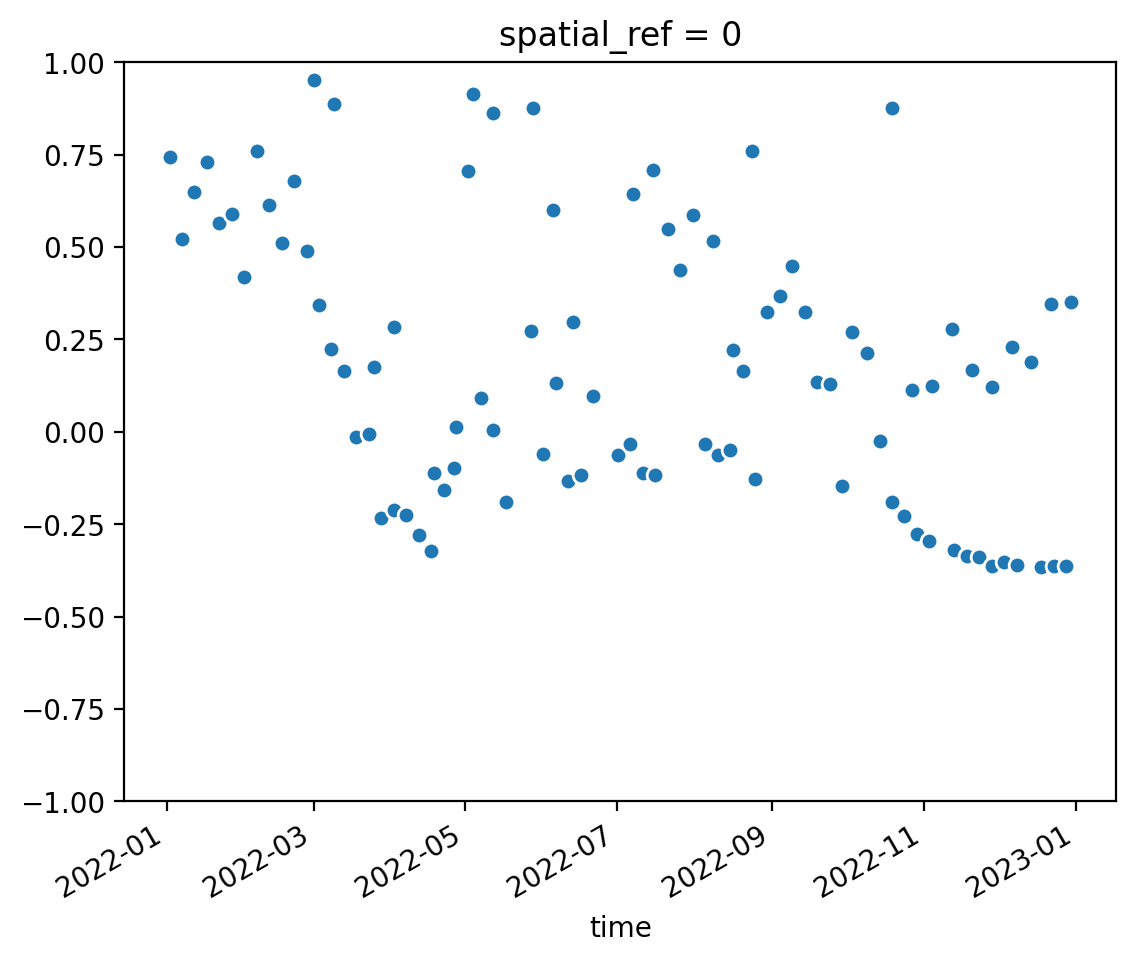

In [48]:
ds_masked = ds_clipped.where(ds_clipped.mask_cloud)

ts = ds_masked.mean(['x','y'])

ndsi = (ts.green - ts.swir16) / (ts.green + ts.swir16)

ndsi.plot.scatter(ylim=(-1,1));

## Notes

Expecting NDSI to be between 0 and 1, so need to do some further digging to figure out masks. 

Use an "easier" area for demo (no glaciers), seasonal snow in eastern washington or colorado...

Plot existing 'snow' mask against NDSI and try in other areas like eastern Sierra (https://www.usgs.gov/landsat-missions/normalized-difference-snow-index). Also do some literature review for known biases.